## 프로젝트: CAM을 만들고 평가해 보자

In [22]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image

import urllib3
urllib3.disable_warnings()

import os

In [2]:
(ds_train, ds_test), ds_info = tfds.load(
    'cars196',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

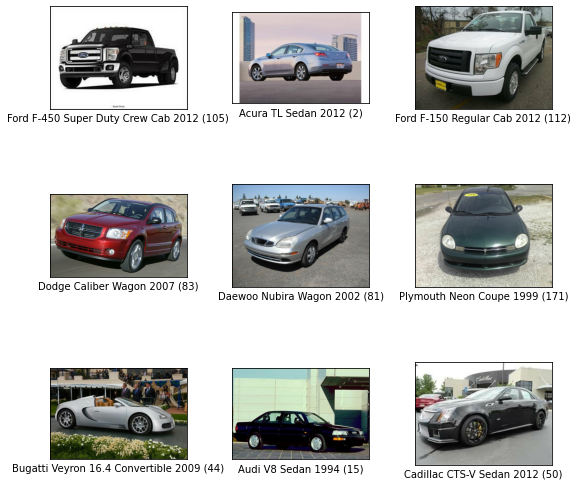

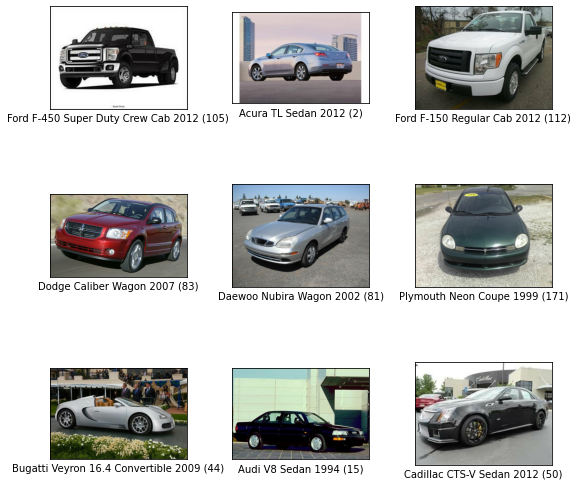

In [3]:
tfds.show_examples(ds_train, ds_info)

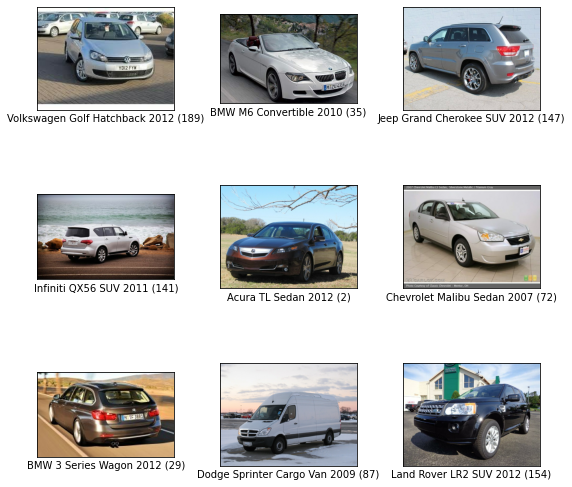

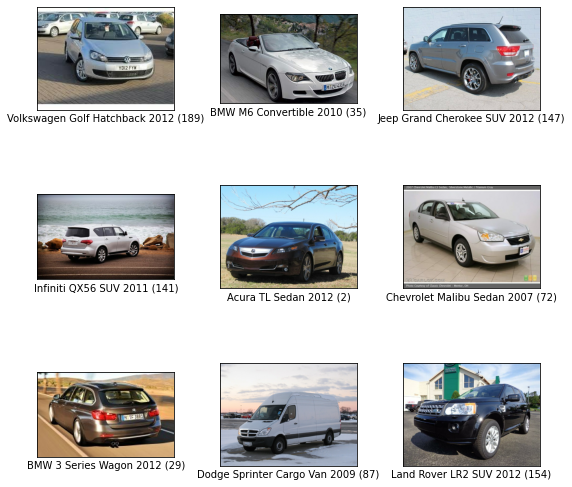

In [4]:
tfds.show_examples(ds_test, ds_info)

In [5]:
ds_info.features

FeaturesDict({
    'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=196),
})

### CAM 구현하기

In [6]:
num_classes = ds_info.features["label"].num_classes
base_model = keras.applications.resnet.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling='avg',  
)
x = base_model.output
preds = keras.layers.Dense(num_classes, activation = 'softmax')(x)
cam_model=keras.Model(inputs=base_model.input, outputs=preds)

In [7]:
cam_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [8]:
def normalize_and_resize_img(input):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

In [9]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [10]:
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_test_norm = apply_normalize_on_dataset(ds_test)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [11]:
for input in ds_train_norm.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

(16, 224, 224, 3)
(16,)


In [12]:
tf.random.set_seed(2021)
cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

In [13]:
history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=15,
    validation_data=ds_test_norm,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15
509/509 [==============================] - 139s 214ms/step - loss: 4.9486 - accuracy: 0.0637 - val_loss: 5.4202 - val_accuracy: 0.0122
Epoch 2/15
509/509 [==============================] - 96s 189ms/step - loss: 2.0660 - accuracy: 0.5442 - val_loss: 1.8313 - val_accuracy: 0.5277
Epoch 3/15
509/509 [==============================] - 91s 180ms/step - loss: 0.7362 - accuracy: 0.8608 - val_loss: 1.4318 - val_accuracy: 0.6304
Epoch 4/15
509/509 [==============================] - 95s 187ms/step - loss: 0.2549 - accuracy: 0.9672 - val_loss: 1.0897 - val_accuracy: 0.7123
Epoch 5/15
509/509 [==============================] - 96s 188ms/step - loss: 0.0854 - accuracy: 0.9945 - val_loss: 1.0614 - val_accuracy: 0.7184
Epoch 6/15
509/509 [==============================] - 96s 190ms/step - loss: 0.0478 - accuracy: 0.9971 - val_loss: 1.0209 - val_accuracy: 0.7267
Epoch 7/15
509/509 [==============================] - 94s 184ms/step - loss: 0.0253 - accuracy: 0.9992 - val_loss: 1.0045 - val_a

In [14]:
cam_model_path = os.getenv('HOME')+'/aiffel/class_activation_map/cam_model.h5'
cam_model.save(cam_model_path)

In [15]:
del cam_model, base_model, ds_train, ds_test, ds_info, ds_train_norm, ds_test_norm

In [16]:
(ds_train, ds_test), ds_info = tfds.load(
    'cars196',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

In [17]:
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

64


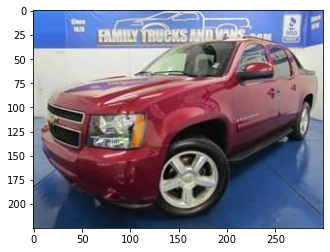

In [18]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])

In [19]:
cam_model = tf.keras.models.load_model(cam_model_path)

In [20]:
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    
    conv_outputs = conv_outputs[0, :, :, :]
    class_weights = model.layers[-1].get_weights()[0]
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image)
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height))
    return cam_image

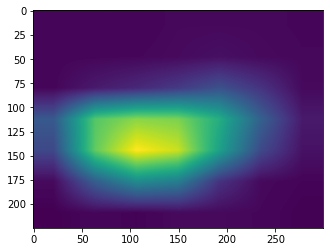

In [23]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)

In [24]:
def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

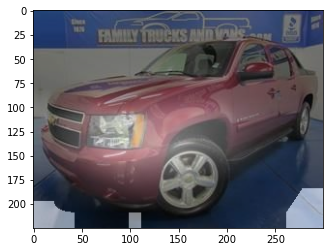

In [25]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)

### Grad-CAM 구현하기

12


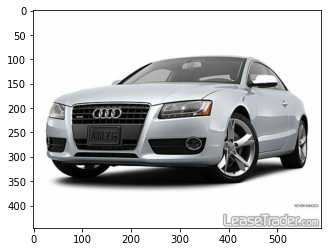

In [26]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])

In [27]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
    
        loss = pred[:, class_idx]
        output = conv_output[0]
        grad_val = tape.gradient(loss, conv_output)[0]

    weights = np.mean(grad_val, axis=(0, 1)) # gradient의 GAP으로 class별 weight를 구합니다.
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

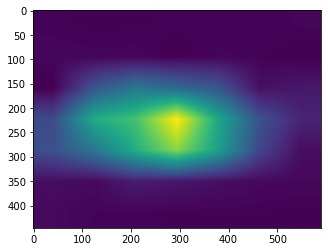

In [31]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)

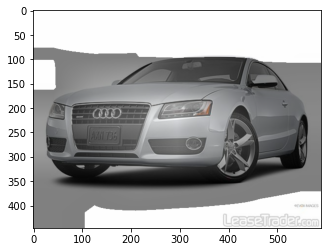

In [33]:
origin_image = item['image'].astype(np.uint8)
grad_cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(grad_cam_image_3channel, origin_image)
plt.imshow(blended_image)

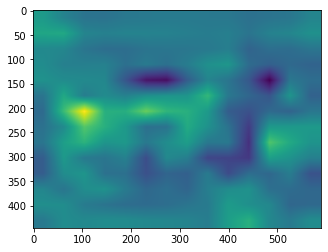

In [34]:
grad_cam_image = generate_grad_cam(cam_model, 'conv4_block3_out', item)
plt.imshow(grad_cam_image)

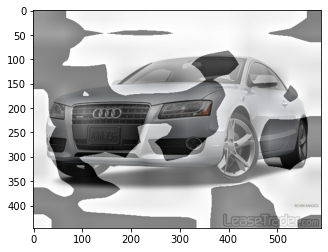

In [35]:
origin_image = item['image'].astype(np.uint8)
grad_cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(grad_cam_image_3channel, origin_image)
plt.imshow(blended_image)

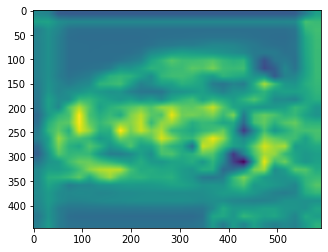

In [36]:
grad_cam_image = generate_grad_cam(cam_model, 'conv3_block3_out', item)
plt.imshow(grad_cam_image)

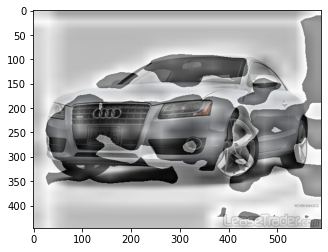

In [37]:
origin_image = item['image'].astype(np.uint8)
grad_cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(grad_cam_image_3channel, origin_image)
plt.imshow(blended_image)

### 바운딩 박스 구하기

29


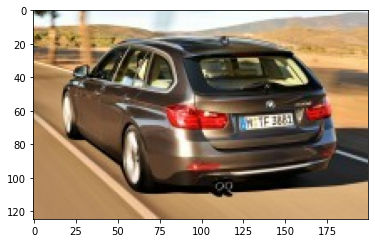

In [38]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])

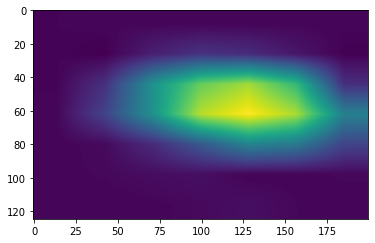

In [39]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)

In [40]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

In [41]:
image = copy.deepcopy(item['image'])
rect = get_bbox(cam_image)
rect

array([[ 21,  15],
       [199,  15],
       [199,  96],
       [ 21,  96]])

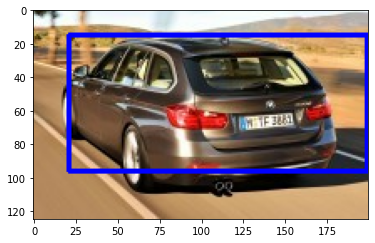

In [42]:
image = cv2.drawContours(image,[rect],0,(0,0,255),2)
plt.imshow(image)

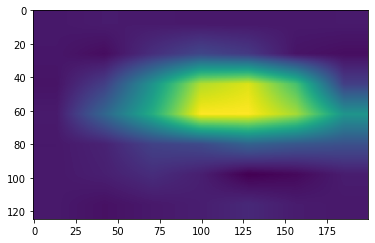

In [62]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)

In [63]:
image = copy.deepcopy(item['image'])
grad_rect = get_bbox(grad_cam_image)
grad_rect

array([[ 16,  20],
       [197,   7],
       [202,  92],
       [ 21, 105]])

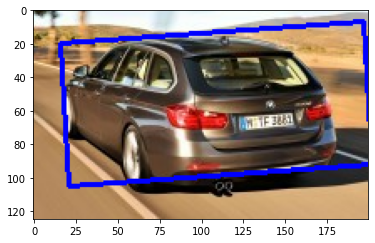

In [64]:
image = cv2.drawContours(image,[grad_rect],0,(0,0,255),2)
plt.imshow(image)

### IoU 구하기

In [53]:
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]), #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]) #bounding box의 x_max
    ]
    return bbox

In [54]:
pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[0.12, 0.105, 0.768, 0.995]

In [66]:
grad_pred_bbox = rect_to_minmax(grad_rect, item['image'])
grad_pred_bbox

[0.056, 0.08, 0.84, 1.01]

In [67]:
item['bbox']

array([0.12 , 0.08 , 0.896, 0.915], dtype=float32)

In [68]:
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

In [69]:
get_iou(pred_bbox, item['bbox'])

0.750042832572482

In [70]:
get_iou(grad_pred_bbox, item['bbox'])

0.7748620658331855

### 결과 정리 및 회고

딥러닝을 공부하며 결과에 대한 명확한 원인을 알지 못하는 경우가 종종 있었기 때문에, 이번 노드의 주제는 매력적이었다.   
Grad CAM은 CAM과 달리 모델의 구조에 직접적인 영향을 미치지 않는 걸로 알고 있다.   
그래서 Grad CAM이 그냥 CAM보다 더 좋은 성능을 낼 것이라고 생각했는데, 생각만큼의 차이는 나지 않았다.   
prediction과 ground truth의 교집합 / prediction과 ground truth의 합집합인 IoU 값을 기준으로, 비교에 사용한 이미지에 대해 각각 0.75, 0.77 정도의 값을 내놨다.   
간단히 생각해보면, ground truth인 bounding box는 차의 모든 부분을 포함하고 있을 것이고, CAM보다 Grad CAM이 차를 더 많이 포함하고 있기 때문에 그런 것 같다.   
단, Grad CAM은 bounding box가 기울어진 만큼 불필요한 배경을 더 많이 포함하기 때문에 차이가 크진 않은 것 같다.